### Import Block

In [213]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance as gpx
import itertools
import datetime as dt
from scipy.sparse import coo_matrix

### Testing Polygon Bounding Box Calculation and FIltering (GeoPandas)

In [4]:
%%time
# Try GeoPandas load.
defo_gpd = gpd.read_file('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

Wall time: 30.7 s


In [5]:
%%time
# Get bouinding boxes.
gpd_bbox = defo_gpd.bounds
gpd_bbox

Wall time: 16.5 s


,minx,miny,maxx,maxy
0,-63.051908,2.596715,-63.048150,2.599951
1,-62.638652,2.697585,-62.636223,2.699288
2,-63.343713,2.781734,-63.339324,2.784656
3,-63.340411,2.783470,-63.339335,2.783835
4,-63.164857,2.634077,-63.162167,2.637574
...,...,...,...,...
599814,-57.407988,-14.430745,-57.397497,-14.421868
599815,-57.477082,-14.389886,-57.474099,-14.386342
599816,-57.404186,-14.396582,-57.403953,-14.396567
599817,-57.399649,-14.421868,-57.399111,-14.421330


In [6]:
# Add bounding boxes to DataFrame.
defo_gpd['x_min'] = gpd_bbox['minx']
defo_gpd['x_max'] = gpd_bbox['maxx']
defo_gpd['y_min'] = gpd_bbox['miny']
defo_gpd['y_max'] = gpd_bbox['maxy']

In [26]:
# Convert date format.
defo_gpd['Date'] = pd.to_datetime(defo_gpd['image_date'])

In [10]:
# Parameters for test.
centroid_lat = -1.672125
centroid_lon = -53.617889
span = 15
centroid_date = dt.datetime.strptime('2017/09/15','%Y/%m/%d')
days_back = 10

# Get start of temporal window.
min_date = centroid_date - dt.timedelta(days = days_back)

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and 100 pixels in all directions.
min_lat = centroid_lat - (lat_step * span)
max_lat = centroid_lat + (lat_step * span)
min_lon = centroid_lon - (lon_step * span)
max_lon = centroid_lon + (lon_step * span)

In [48]:
centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
               (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
               (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
               (defo_gpd['Date'] <= min_date)]

In [49]:
centroid_defo

,uid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,...,source,satellite,sensor,uuid,geometry,x_min,x_max,y_min,y_max,Date
32235,451935,PA,22761,DESMATAMENTO,d2015,0.0,226.0,2015-08-14,2015.0,0.161589,...,None,None,None,5435c1b1-2334-483b-b95e-a9fb5119549b,"POLYGON ((-53.64548 -1.64330, -53.64548 -1.643...",-53.645485,-53.641851,-1.649479,-1.642757,2015-08-14
222024,416086,PA,22761,DESMATAMENTO,d2008,0.0,271.0,2008-09-27,2008.0,0.079449,...,None,None,None,343697c2-63f7-402d-bcf7-39c6373d1c08,"POLYGON ((-53.62117 -1.62661, -53.61875 -1.626...",-53.621175,-53.617140,-1.630111,-1.626611,2008-09-27
451199,451929,PA,22761,DESMATAMENTO,d2015,0.0,226.0,2015-08-14,2015.0,0.075871,...,None,None,None,78a8253e-846b-4bc8-a9f1-20fdd6ab2e8b,"POLYGON ((-53.62424 -1.64168, -53.62423 -1.641...",-53.624243,-53.620468,-1.643292,-1.640230,2015-08-14
531519,416094,PA,22761,DESMATAMENTO,d2008,0.0,271.0,2008-09-27,2008.0,0.115781,...,None,None,None,c761443c-bdd5-4b52-9935-8e229602fc63,"POLYGON ((-53.60110 -1.63737, -53.60110 -1.637...",-53.601100,-53.594106,-1.638719,-1.635488,2008-09-27


In [149]:
lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
cs = [c for c in range(0,span * 2 + 2)]
grid = list(itertools.product(lons, lats))
grid_xy = list(itertools.product(cs, cs))

In [150]:
grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
grid_gdf = gpd.GeoDataFrame(grid_points).set_geometry(0)
grid_gdf['x'] = [c[0] for c in grid_xy]
grid_gdf['y'] = [c[1] for c in grid_xy]

In [31]:
%%time
res = []
for p in grid_points:
    res.append(centroid_defo['geometry'].contains(p))

Wall time: 45.9 ms


In [32]:
pd.concat(res).value_counts()

False    4093
True        3
dtype: int64

In [33]:
pd.concat(res)[pd.concat(res) == True]

32235     True
451199    True
531519    True
dtype: bool

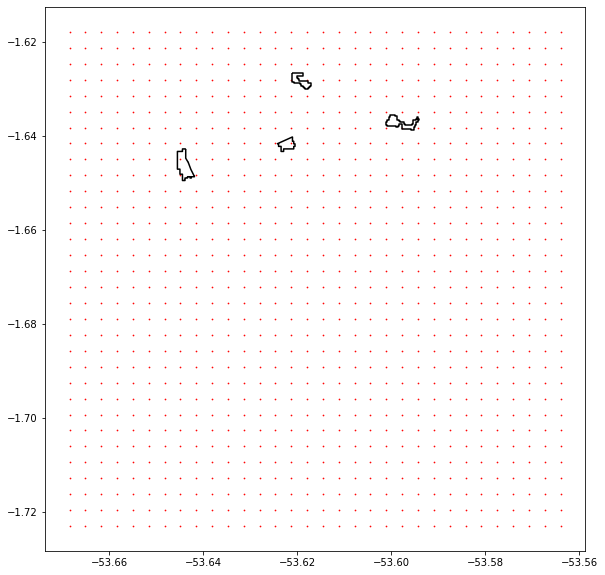

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

centroid_defo.boundary.plot(ax=ax, edgecolor='black')
grid_gdf.set_geometry(0).plot(ax=ax, color='red', markersize=0.5)

plt.show()

### Dataset Construction

In [223]:
# Parameters for test.
centroid_lat = -1.672125
centroid_lon = -53.617889
span = 15
centroid_date = dt.datetime.strptime('2017/09/15','%Y/%m/%d')
days_back = 10

# Get start of temporal window.
min_date = centroid_date - dt.timedelta(days = days_back)

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and 100 pixels in all directions.
min_lat = centroid_lat - (lat_step * span)
max_lat = centroid_lat + (lat_step * span)
min_lon = centroid_lon - (lon_step * span)
max_lon = centroid_lon + (lon_step * span)

# Limit deforestation polygons to those that intersect with centroid grid.
centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
               (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
               (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
               (defo_gpd['Date'] <= min_date)]

# Build grid.
lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
cs = [c for c in range(0,span * 2 + 2)]
grid = list(itertools.product(lons, lats))
grid_xy = list(itertools.product(cs, cs))
grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
grid_gdf = gpd.GeoDataFrame(grid_points)
grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
grid_gdf['x'] = [c[0] for c in grid_xy]
grid_gdf['y'] = [c[1] for c in grid_xy]
grid_gdf = grid_gdf.set_geometry('geometry')
grid_gdf.crs = 'epsg:4674'

# Calculate deforested gridpoints.
grid_gdf['deforested'] = np.minimum(pd.concat(
    [grid_gdf.within(centroid_defo.iloc[x].geometry) for x in range(0,len(centroid_defo))]
    , axis=1).sum(1),1)

# Convert to numpy format.
dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()